# Timeline for scripts of the DESIRE database


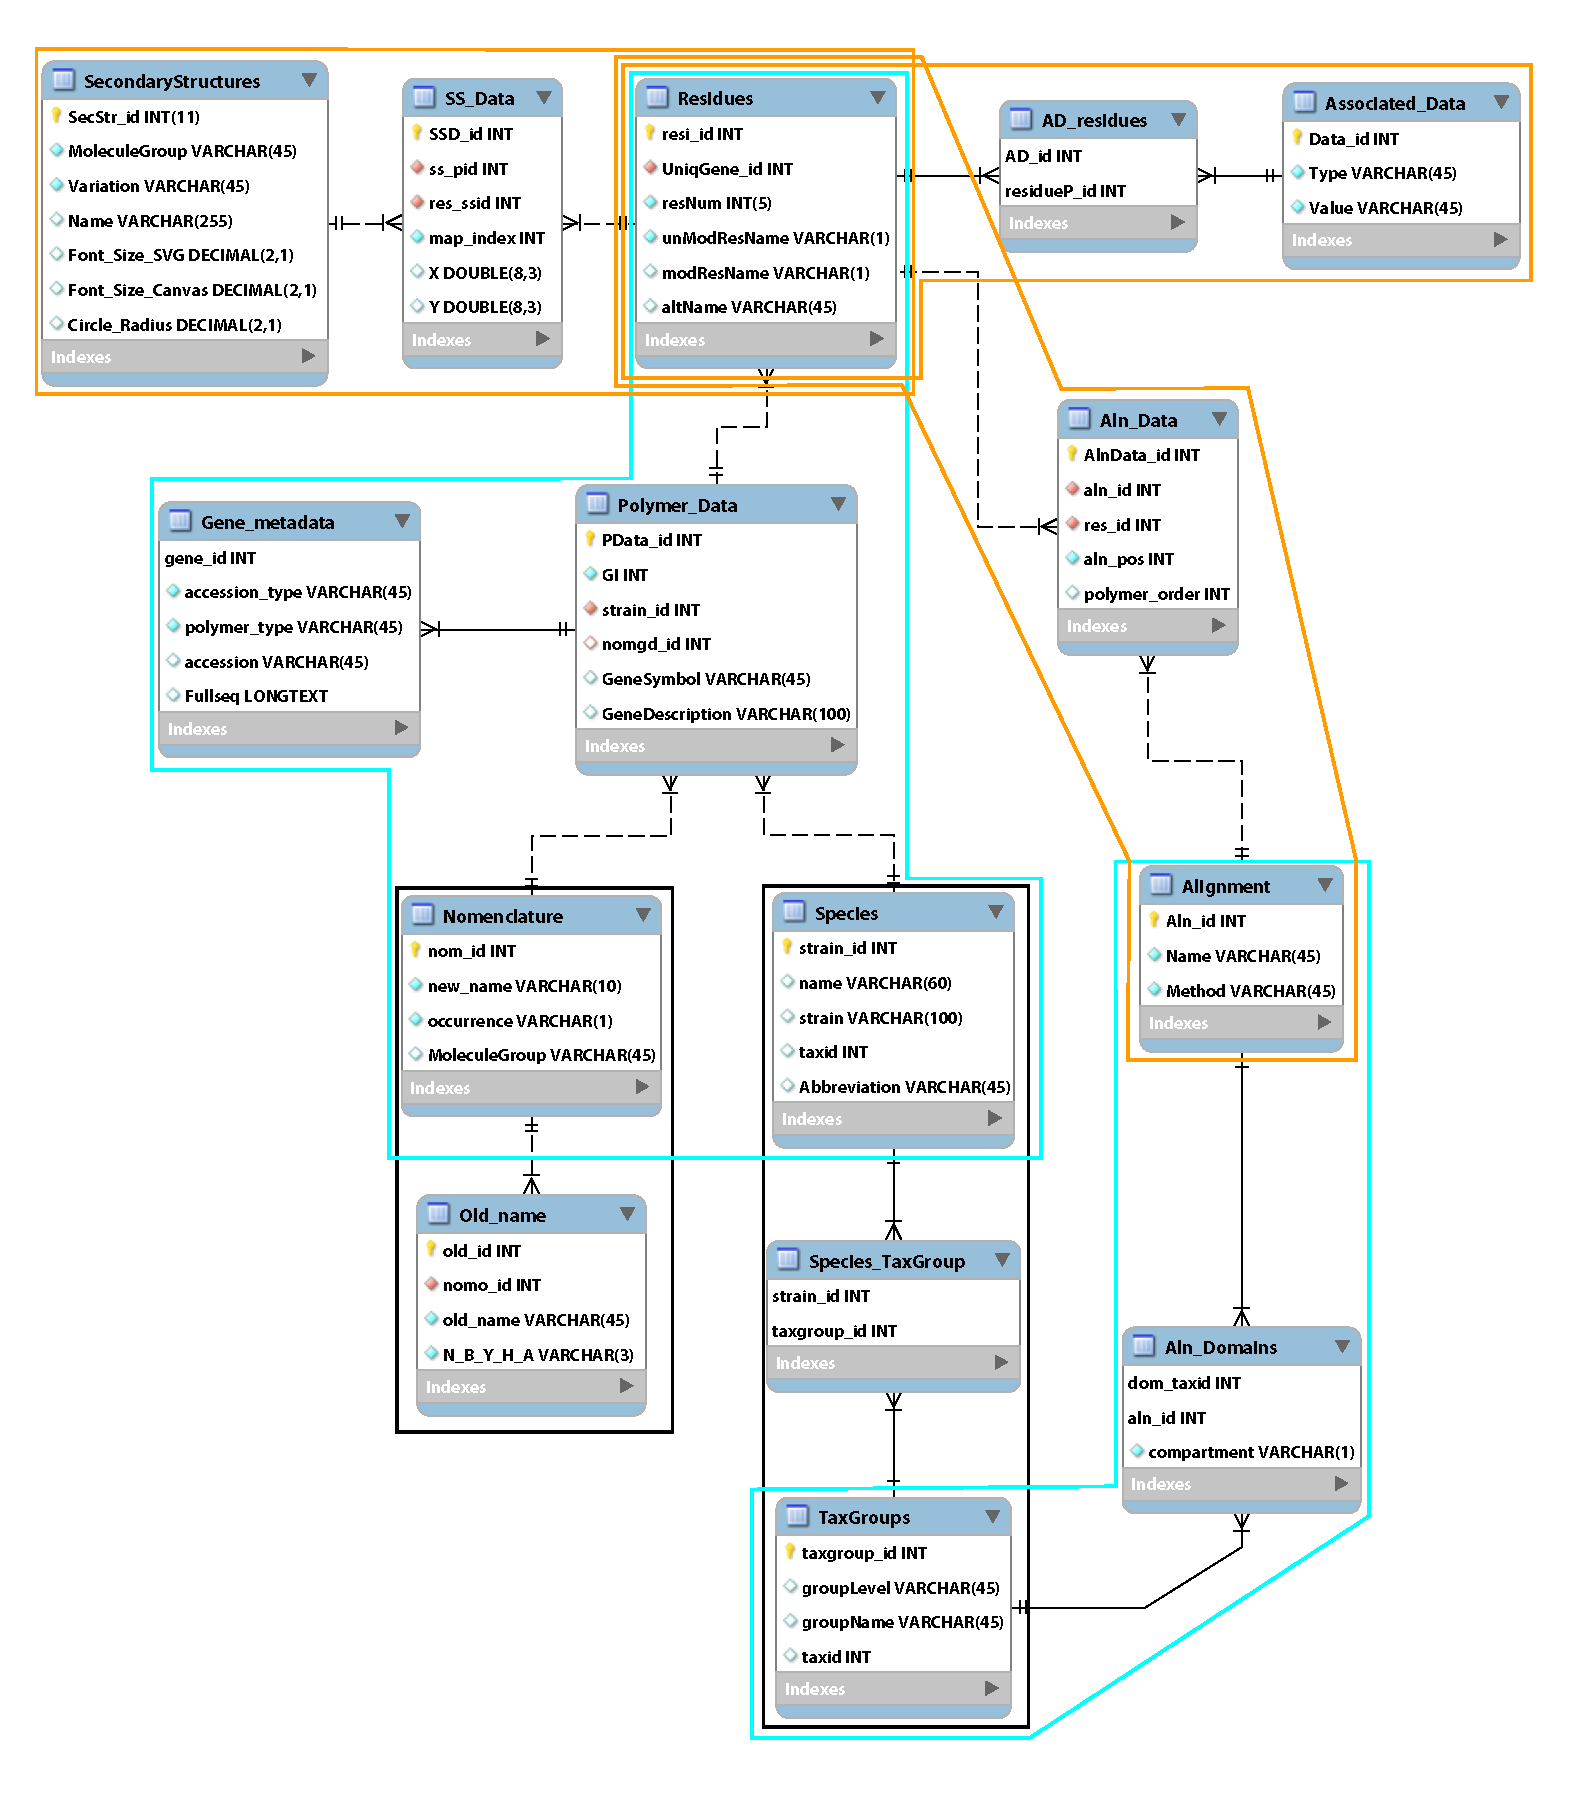


Each outline describes a script for updating the database. **Black** outlines are scripts that do not require prior tables to be completed.  <span style="color:cyan">Cyan</span> outline is for scripts that require tables from black scripts.  <span style="color:Orange">Yellow </span> requires tables from <span style="color:cyan">Cyan</span> and bellow.


## Surrogate keys
As of now the major question is whether we want auto-incrementing (AI) keys (aka *surrogate keys*) for most of the tables. This will make things easier in the future, but markedly harder now. The scripts which update the tables will need to query tables for the surrogate keys and associate them with the correct data in order to update other tables.

We will HAVE to use surrogate keys for tables like **Gene_sequences_type**. <span style="color:red">(Substituted for Gene_metadata)</span>

### Nomenclature
I would like to try as a test and see how surrogate keys would work in the **Nomenclature** and **Old_name** tables. With *nom_id* being an AI surrogate key for **Nomenclature** and *nomo_id* being a foreign key of *nom_id* in the **Old_name** table. 

The idea of the current design for **Nomenclature** and **Old_name** is to allow for multiple repeated *new_name* entries, which have different *occurence*s (which can specify both the domain and the cellular localization - B,A,E (assumes cytozol) or m,c). The the association with **Old_name** is done through the unique AI surrogate key *nom_id*. *old_id* will also be AI. 

Because there were different names used for *H. sapiens* and *S. cerevisiae* we might need another column in **Old_name** which specifies that (the *occurence* will be the same since they are both E). **DONE** (*yeast-human*)

### Species
For some model organisms there are many strains/substrains etc. For now I have experinced this with *E. coli K-12* (txid 83333). In my work up to now this was supposed to be the leaf identifier for the *E. coli* specie, however it seems that there are many substrains which show up when we query Entrez for all the genes from txid 83333:

> esearch -db gene -query "txid83333[Organism]" | efetch -format tabular

This returns many results from different substrains of the K-12. <span style="color:blue">I propose we use **511145** *Escherichia coli str. K-12 substr. MG1655* as our leaf identifier.</span> In principle this is not a cause to change the design of the **Species**, **Species_TaxGroup**, and **TaxGroups** tables. All that has to be done is check for the model organisms that would show similar behaviour (for example *S. cerevisiae*) and add the appropriate leaf taxids in the **Species** table, as well as the connections to the **Species_TaxGroup**. This should already be possible through Vasanta's script.

### Gene_metadata (previously Gene_Sequences_Type)

#### Reverse complement nucleotidic sequences
We will have for starters 3 *polymer_type*s (in the future we can add stuff like depsipeptides) in the **Gene_Sequences_Type**. One *protein*, one back-translated *nucl*eotidic (from the transl-aln.py script) and one *nucl_rev* which will be the reverse complement of the *nucl*.

### Residues
In essence should be the heart of the database, since it distinguishes our data at the lowest level.
Should define positions of residues in the protein/RNA raw sequence (**Gene_metadata**.*Fullseq*). It will:

1. Send foreign keys to **Alignment_Data** defining which residue is in what position (*alignment_pos*) based on a particular alignment.
2. Send foreign keys to **Secondary_structure_residues** defining which residue goes in which secondary structure (with key *variation*, *molecule_group*, and *specie*) and it's *map_index* (= *res2index*) (position in relation to other participants in the SSE).
3. Send foreign keys to **Tertiary_structure_residues** defining which residue goes in which 3D structure (definied by *chain* and *pdb_id* (should be inherently connected to *specie*)) The difference in numbering will be resolved in here (*resAltNum* = *res3index*)

# Merging Sequence and Structure DBs

Our aim is to achieve complete integration between sequence and structure data. There are 4 pairs of tables which will act as interface between the two databases:

**Sequence** - **Structure**
1. **Species** - **Species**
2. **Residues** - **Residues**
3. **Alignment** - **Secondary_structure_residues** (Likely not needed)
4. **Gene_data** - **Polymers**

### Species  <span style="color:lightgreen">PROGRESSING</span>
Does not require much reworking, we should just add column *Abbreviation* and merge the two tables.

### Residues <span style="color:lightgreen">PROGRESSING</span>
Should move *map_index* from the structural residues to **Secondary_structure_residues**.

Should connect through **SS_Data** in a m-n relationship with **SecondaryStructures**.

### Alignment <span style="color:green">REMOVED</span>
Not yet conceptualized. (Not needed)

### Polymer_Data <span style="color:green">DONE</span> previously Gene_data
Many columns in **Polymers** are redundant with information present in other tables:
- *molecule_name_long* - present in **Nomenclature**.*new_name* or *gene_symbol* and *gene_description* in **Gene_Data**.
- *molecule_name_short* - unneded (can be treated as another old name in **Old_name**)
- *Molecule_type* - same as **Gene_metadata**.*polymer_type*
- *Molecule_group* - for rProteins is already present in their name (L or S), however it might be needed for rRNA and other proteins. It should be added to **Gene_metadata**. Can be in Nomenclature?



# Redesign due to discontinued problems with NCBI Gene DB

Instead of **Gene_sequences_type** we have a metadata table for the genes. We will not use the gene identifier so strictly, since several species are missing entries in the Gene DB. Furthermore, for many entries in the Gene DB a discontinued label has been applied. To solve this we will use GI when available and when it is not we will use protein accession. The metadata table will hold information which accession is being used and what is the polymer, sine the Gene_Data PK will be an auto-incremental surrogate key, this shouldn't pose any problems.

The other tables connecting to **Gene_sequences_type** will connect to **Gene_Data** instead.

# Residues will connect sequence and structural data

